In [1]:
!pip install rouge
import numpy as np
import pandas as pd
import pickle
import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from rouge import Rouge

DEPRECATION: pytorch-lightning 1.5.10 has a non-standard dependency specifier torch>=1.7.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
df = pd.read_csv("./input/train.csv")

In [3]:
#df.head()

In [4]:
df.isnull().sum()

id            0
article       0
highlights    0
dtype: int64

In [5]:
df.drop_duplicates(inplace=True,ignore_index=True)
df.shape

(287113, 3)

In [6]:
df['article'].apply(lambda x: len(str(x))).sort_values(ascending=True)

137538       48
56939       106
205333      106
100845      117
225947      145
          ...  
174741    12654
219866    12656
75395     12666
7367      14659
51997     15925
Name: article, Length: 287113, dtype: int64

In [7]:
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)

In [8]:
df['article'].apply(lambda x: len(str(x))).sort_values(ascending=True)

137538       48
56939       106
205333      106
100845      117
225947      145
          ...  
174741    12654
219866    12656
75395     12666
7367      14659
51997     15925
Name: article, Length: 287113, dtype: int64

In [9]:
df['highlights'].apply(lambda x: len(str(x))).sort_values(ascending=True)

64142       14
151493      25
137867      28
268063      32
230207      34
          ... 
3905      4191
199305    5419
76414     6147
206388    6959
59756     7388
Name: highlights, Length: 287113, dtype: int64

In [10]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [11]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)

    return text

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
clean_story = []
for text in df['article']:
    clean_story.append(clean_text(text))
print('Cleaning story Complete')

Cleaning story Complete


In [14]:
clean_summaries = []
for summary in df['highlights']:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete')

Cleaning Summaries Complete


In [15]:
print(len(clean_story))
print(len(clean_summaries))

287113
287113


In [16]:
clean_df = pd.DataFrame()
clean_df['story'] = clean_story
clean_df['summary'] = clean_summaries
clean_df['summary'].replace('', np.nan, inplace=True)
clean_df.dropna(axis=0, inplace=True)

In [17]:
clean_df['story'][0:10]

0    associated press published 14 11 est 25 octobe...
1    cnn ralph mata internal affairs lieutenant mia...
2    drunk driver killed young woman head crash che...
3    cnn breezy sweep pen president vladimir putin ...
4    fleetwood team still 100 record sky bet league...
5    accused making many fashion faux pas holiday p...
6    daily mail reporter published 01 15 est 30 nov...
7    daily mail reporter moment train announcer stu...
8    number job descriptions waiting darren fletche...
9    canberra australia cnn first glance look like ...
Name: story, dtype: object

In [18]:
clean_df.to_csv("./input/CNN_Preprocess.csv")
df2 =pd.read_csv("./input/CNN_Preprocess.csv")

In [19]:
df2 = df2.drop(['Unnamed: 0'],axis=1)

print(df2.shape)
df2.head()

(287112, 2)


,story,summary
0,associated press published 14 11 est 25 octobe...,bishop john folda of north dakota is taking ...
1,cnn ralph mata internal affairs lieutenant mia...,criminal complaint cop used his role to help ...
2,drunk driver killed young woman head crash che...,craig eccleston todd 27 had drunk at least t...
3,cnn breezy sweep pen president vladimir putin ...,nina dos santos says europe must be ready to a...
4,fleetwood team still 100 record sky bet league...,fleetwood top of league one after 2 0 win at s...


In [20]:
final_story =[]
final_summary =[]

for i, sty in enumerate(df2['story']):
    sty_len = len(sty.split())
    sumy_len = len(df2['summary'][i].split())
  #print("story & summary len...",sty_len,sumy_len)
    if (sty_len > sumy_len) & (sty_len >50) & (sty_len <=300) & (sumy_len <=50):
        final_story.append(sty)
        final_summary.append(df2['summary'][i])

In [21]:
print(len(final_story))
print(len(final_summary))

74282
74282


In [22]:
#clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')

In [23]:
#clean_df['summary'][0]

In [24]:
df_final=pd.DataFrame({'story':final_story,'summary':final_summary})
df_final.head(2)

,story,summary
0,associated press published 14 11 est 25 octobe...,bishop john folda of north dakota is taking ...
1,cnn ralph mata internal affairs lieutenant mia...,criminal complaint cop used his role to help ...


In [25]:
df_final['summary'] = df_final['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')
df_final.head(2)

,story,summary
0,associated press published 14 11 est 25 octobe...,<sostok> bishop john folda of north dakota i...
1,cnn ralph mata internal affairs lieutenant mia...,<sostok> criminal complaint cop used his role...


In [26]:
train_x, test_x, train_y, test_y = train_test_split(df_final['story'], df_final['summary'], test_size=0.2, random_state=0)

In [27]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value



In [28]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  58.488817030450015
Total Coverage of rare words:  1.286727795064684
Text Vocab:  77024


In [29]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [30]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  71.48471238555881
Total Coverage of rare words:  3.855894297662349
Summary Vocab:  19809


In [31]:
maxlen_text = 300
maxlen_summ = 50

In [32]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [33]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [34]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (59425, 300)
Target Values Shape (59425, 50)
Test Sequence (14857, 300)
Target Test Shape (14857, 50)


In [35]:
embeding_index = {}
embed_dim = 100
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [36]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [37]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

In [38]:
#s_tokenizer.index_word

In [39]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=True)(enc_input)
# h_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# h_out, _, _ = h_lstm(enc_embed)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=True)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 300, 100)             7702400   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 bidirectional (Bidirection  [(None, 256),                234496    ['embedding[0][0]']           
 al)                          (None, 128),                                                   

In [40]:
#plot_model(
#    model,
#    to_file='/content/drive/MyDrive/Colab Notebooks/Dataset/seq2seq_encoder_decoder.png',
#    show_shapes=True,
#    show_layer_names=True,
#    rankdir='TB',
#    expand_nested=False,
#    dpi=96)

In [41]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

In [42]:
history = model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:],
          epochs=10, callbacks=[early_stop], batch_size=128, verbose=1,
          validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/10


465/465 [==============================] - 702s 2s/step - loss: 5.5972 - accuracy: 0.2985 - val_loss: 5.2934 - val_accuracy: 0.3152
Epoch 2/10
465/465 [==============================] - 715s 2s/step - loss: 5.2102 - accuracy: 0.3238 - val_loss: 5.0494 - val_accuracy: 0.3324
Epoch 3/10
465/465 [==============================] - 713s 2s/step - loss: 5.0078 - accuracy: 0.3358 - val_loss: 4.8710 - val_accuracy: 0.3448
Epoch 4/10
465/465 [==============================] - 716s 2s/step - loss: 4.8690 - accuracy: 0.3427 - val_loss: 4.7583 - val_accuracy: 0.3488
Epoch 5/10
465/465 [==============================] - 703s 2s/step - loss: 4.7606 - accuracy: 0.3473 - val_loss: 4.6550 - val_accuracy: 0.3541
Epoch 6/10
465/465 [==============================] - 696s 1s/step - loss: 4.6715 - accuracy: 0.3510 - val_loss: 4.5778 - val_accuracy: 0.3576
Epoch 7/10
465/465 [==============================] - 696s 1s/step - loss: 4.5975 - accuracy: 0.3544 - val_loss: 4.5172 - val_accuracy: 0.36

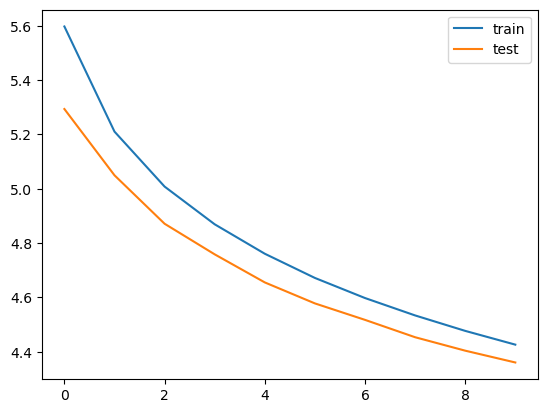

In [43]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [44]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [45]:
import pickle

# Save encoder model
enc_model.save('./models/baseline_abs/encoder_modelBiLSTM.h5')

# Save decoder model
dec_model.save('./models/baseline_abs/decoder_modelBiLSTM.h5')

# Save tokenizer
with open('./models/baseline_abs/s_tokenizerBiLSTM.pkl', 'wb') as f:
    pickle.dump(s_tokenizer, f)
model.save_weights('./models/baseline_abs/summarizationBiLSTM_weights.h5')

D:\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
# Load the model
enc_model = tf.keras.models.load_model('./models/baseline_abs/encoder_modelBiLSTM.h5')
dec_model = tf.keras.models.load_model('./models/baseline_abs/decoder_modelBiLSTM.h5')

In [47]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq,verbose=0)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c],verbose=0)
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq


In [48]:
df_test = pd.read_csv("./input/test_cleaned.csv", nrows = 10)

In [49]:
test_data = df_test.drop(['id'], axis=1)
test_data = test_data.reset_index(drop=True)

In [50]:
test_data.shape

(10, 3)

In [51]:
test_final_story =[]
test_final_summary =[]

for i, sty in enumerate(test_data['article']):
    sty_len = len(sty.split())
    sumy_len = len(test_data['highlights'][i].split())
  #print("story & summary len...",sty_len,sumy_len)
    if (sty_len > sumy_len) & (sty_len >50) & (sty_len <=300) & (sumy_len <=50):
        test_final_story.append(sty)
        test_final_summary.append(test_data['highlights'][i])

In [52]:
print(len(test_final_story))
print(len(test_final_summary))

df_testfinal=pd.DataFrame({'story':test_final_story,'summary':test_final_summary})
df_testfinal.to_csv("test863.csv")

1
1


In [53]:
test_inputs = [clean_text(sent) for sent in df_testfinal['story']]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [54]:
test_inputs.shape

(1, 300)

In [55]:

#maxlen_text

In [56]:
hyps = []
with open('result.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(len(test_final_story)):
        print(i)
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([df_testfinal['story'][i], df_testfinal['summary'][i], our_summ])

0


In [57]:
def generate2_summary2(input_text):
    # Load the tokenizer
    with open('./models/baseline_abs/s_tokenizerBiLSTM.pkl', 'rb') as f:
        s_tokenizer = pickle.load(f)

    # Load the model
    enc_model = tf.keras.models.load_model('./models/baseline_abs/encoder_modelBiLSTM.h5')
    dec_model = tf.keras.models.load_model('./models/baseline_abs/decoder_modelBiLSTM.h5')

    # Tokenize the input text
    input_seq = s_tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=300, padding='post')

    # Generate the summary
    h, c = enc_model.predict(input_seq,verbose=0)

    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''

    stop = False
    count = 0

    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c],verbose=0)
        token_idx = np.argmax(decoder_out[0, -1, :])

        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token

        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1

    return output_seq.strip()

In [58]:
text = df_testfinal['story'][0]
print("text : ",text)
get_sum_for_text = generate2_summary2(text)
print("\nsummary : ",get_sum_for_text)

text :  Dougie Freedman is on the verge of agreeing a new two year deal to remain at Nottingham Forest. Freedman has stabilised Forest since he replaced cult hero Stuart Pearce and the club s owners are pleased with the job he has done at the City Ground. Dougie Freedman is set to sign a new deal at Nottingham Forest . Freedman has impressed at the City Ground since replacing Stuart Pearce in February . They made an audacious attempt on the play off places when Freedman replaced Pearce but have tailed off in recent weeks. That has not prevented Forest s ownership making moves to secure Freedman on a contract for the next two seasons.

summary :  the new york is a new york for the new york city the new york is a new york city in the new york city the new york is a new york city in the new york


In [59]:
rouge = Rouge()
rouge.get_scores(hyps, df_testfinal['summary'], avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.17857142857142858,
  'p': 0.3333333333333333,
  'f': 0.23255813499188757},
 'rouge-2': {'r': 0.03225806451612903,
  'p': 0.05555555555555555,
  'f': 0.04081632188254947},
 'rouge-l': {'r': 0.17857142857142858,
  'p': 0.3333333333333333,
  'f': 0.23255813499188757}}

**2 models**